In [35]:
import reframed
from pathlib import Path
import pandas as pd
import numpy as np
import sys
sys.path.append('../code')
import leakage_reframed

import utils
from dFBA_reframed import dFBA, FBA_with_leakage2, get_leaky_metabolites, FBA_with_leakage
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy

In [4]:
def predict_leakage_rates_from_sp(model, leak_mets, leak_exchanges, shadow_prices,
                                  slope, intercept, noise = None):
    rate_noise = np.zeros(len(leak_mets))
    if isinstance(noise, dict):
        if noise.get('slope'):
            slope_noise = np.random.normal(0, noise['slope'])
            slope = slope + slope_noise
            logging.info(f'Slope noise: {slope_noise}')

        if noise.get('rates'):
            rate_noise = np.random.normal(0, noise['rates'], len(leak_mets))
            logging.info(f"Adding rate noise with std: {noise['rates']}")
    predicted_log_leakage_rates = {}
    predicted_metabolite_values = {}
    for i, (m_id, r_ex_id) in enumerate(zip(leak_mets, leak_exchanges)):
        metabolite_value = - shadow_prices[m_id]
        if np.isfinite(metabolite_value) and metabolite_value > 1e-7:
            # Use trendline from fit 
            lograte = intercept + slope*np.log10(metabolite_value) + rate_noise[i]
            print(m_id, np.log10(metabolite_value), lograte)
            predicted_log_leakage_rates[r_ex_id] = lograte
            predicted_metabolite_values[r_ex_id] = metabolite_value
    return predicted_metabolite_values, predicted_log_leakage_rates
    
    
    
    

# Mapping

In [5]:
mapping_df = pd.read_csv('../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Load data from paczia

In [6]:
data_folder =  Path("../data/e_coli/")
organism = 'e_coli'

In [7]:
ecoli_gDW_per_OD = 0.32

In [8]:
exometabolites_folder = Path(data_folder)

# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [9]:
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

# Estimate max glucose uptake rate
Answer = 8 mmol/gDW/h

In [10]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [11]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*0.32
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

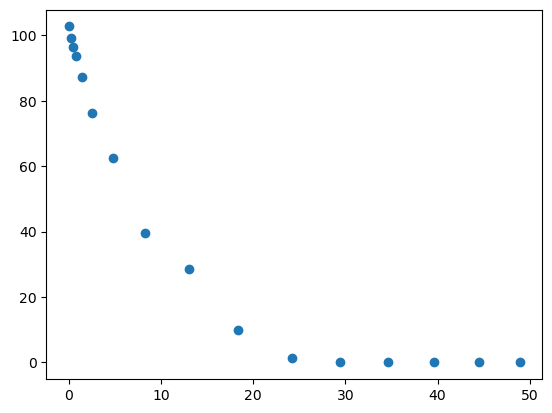

In [12]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [13]:
np.polyfit(df_OD.loc[1:7, 'Cum OD gDW'], df_glucose.loc[1:7, 'Glucose mM'], 1)

array([ -8.39201233, 100.36575098])

# Load model and run simulation

In [14]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
# model = reframed.load_cbmodel('../models/e_coli/iJO1366.xml')
model.solver = 'gurobi'

In [15]:
model.reactions.R_ER_pool_TG_.ub = 0.095
model.reactions.R_ATPM.lb = 3.15
model.reactions.R_EX_cbl1_e.lb = -0.01

In [16]:
for r_id in model.get_exchange_reactions():
    model.reactions[r_id].ub = 1000

## Add exchanges

In [17]:
measured_exchanges = []
for met_abbr, id_string in met_abrv_to_id.items():
    if not isinstance(id_string, str):
        continue
    for m_id in id_string.split(','):
        r_id = f'R_EX_{m_id}_e'
        if r_id in model.reactions:
            measured_exchanges.append(r_id)



In [18]:
fva = reframed.FVA(model, obj_frac = 0.9, reactions=measured_exchanges, constraints={'R_EX_glc__D_e':-10})

Set parameter Username


2023-12-10 01:07:07 INFO:gurobipy.gurobipy Set parameter Username


Academic license - for non-commercial use only - expires 2024-02-26


2023-12-10 01:07:07 INFO:gurobipy.gurobipy Academic license - for non-commercial use only - expires 2024-02-26


In [19]:
# mets_without_transport = []
# for r_id, fva_res in fva.items():
#     if fva_res[1] <= 0:
#         m_id = r_id[5:-2]
#         try:
#             r_ids_p = model.get_metabolite_reactions(f'M_{m_id}_p')
#         except KeyError:
#             mets_without_transport.append(m_id)
#         else:
#             r_ids_c = model.get_metabolite_reactions(f'M_{m_id}_c')
#             transport_reactions = [x for x in r_ids_c if x in r_ids_p]
#             for r_id in transport_reactions:
#                 model.reactions[r_id].lb = -1000
# model.reactions.R_R5PPpp.lb = -1000

In [20]:
# fva = reframed.FVA(model, obj_frac = 0.9, reactions=measured_exchanges, constraints={'R_EX_glc__D_e':-10})

In [21]:
# for r_id, fva_res in fva.items():
#     if fva_res[1] <= 0:
#         measured_exchanges.remove(r_id)

In [22]:
leak_mets, leak_exchanges = get_leaky_metabolites(model, constraints={'R_EX_glc__D_e': -8}, fraction_of_optimum=0.9)

Candidate metabolites 68:
['M_26dap__M_c', 'M_ac_c', 'M_acgam1p_c', 'M_acser_c', 'M_ade_c', 'M_adn_c', 'M_akg_c', 'M_ala_B_c', 'M_ala__D_c', 'M_ala__L_c', 'M_alaala_c', 'M_amp_c', 'M_arg__L_c', 'M_asn__L_c', 'M_asp__L_c', 'M_btn_c', 'M_cit_c', 'M_cmp_c', 'M_cys__L_c', 'M_ddca_c', 'M_dha_c', 'M_dtmp_c', 'M_dump_c', 'M_f6p_c', 'M_for_c', 'M_fum_c', 'M_g6p_c', 'M_gam6p_c', 'M_gdp_c', 'M_gln__L_c', 'M_glu__L_c', 'M_gly_c', 'M_glyc3p_c', 'M_glyclt_c', 'M_gmp_c', 'M_gtp_c', 'M_hdca_c', 'M_hdcea_c', 'M_his__L_c', 'M_hom__L_c', 'M_ile__L_c', 'M_imp_c', 'M_indole_c', 'M_kdo2lipid4_c', 'M_leu__L_c', 'M_lys__L_c', 'M_mal__L_c', 'M_meoh_c', 'M_met__L_c', 'M_orn_c', 'M_orot_c', 'M_phe__L_c', 'M_pheme_c', 'M_pnto__R_c', 'M_pro__L_c', 'M_pser__L_c', 'M_pyr_c', 'M_r5p_c', 'M_ser__L_c', 'M_skm_c', 'M_succ_c', 'M_thr__L_c', 'M_trp__L_c', 'M_tyr__L_c', 'M_uacgam_c', 'M_ump_c', 'M_val__L_c', 'M_xmp_c']


In [23]:
metabolites = [f'M_{m_id}_c' for m_id in met_abrv_to_id.values() if f'M_{m_id}_c' in model.metabolites]
shadow_prices = leakage_reframed.estimate_shadow_prices(model, constraints={'R_EX_glc__D_e':-10}, metabolites = leak_mets)

In [32]:
predicted_metabolite_values, predicted_log_leakage_rates = predict_leakage_rates_from_sp(
    model, leak_mets, leak_exchanges, shadow_prices, slope = -3, intercept=-4
)
solution = reframed.pFBA(model, constraints={'R_EX_glc__D_e': -8})

M_ac_c -1.5528937235007239 0.658681170502172
M_acser_c -1.1209346275422538 -0.6371961173732386
M_ade_c -1.0485699604147471 -0.8542901187557588
M_adn_c -0.7532060286458601 -1.7403819140624197
M_akg_c -1.171344131020729 -0.4859676069378125
M_ala__D_c -1.3214996559779424 -0.03550103206617283
M_ala__L_c -1.321499655977538 -0.035501032067386085
M_alaala_c -1.0019862546218434 -0.9940412361344695
M_arg__L_c -0.9548737099753819 -1.135378870073854
M_asn__L_c -1.2438947981706026 -0.26831560548819233
M_asp__L_c -1.276687311563122 -0.1699380653106335
M_cit_c -1.1150257679312368 -0.65492269620629
M_cys__L_c -1.0300149782249157 -0.9099550653252528
M_dha_c -1.3030162502851463 -0.09095124914456099
M_for_c -2.101245684328489 2.3037370529854666
M_glu__L_c -1.1209346275408523 -0.6371961173774432
M_gly_c -1.5777173072231827 0.7331519216695481
M_glyc3p_c -1.1989276526507877 -0.4032170420476371
M_glyclt_c -1.5571417011584485 0.6714251034753458
M_his__L_c -0.9528490234090657 -1.1414529297728029
M_hom__L_c -1

In [104]:
solution = reframed.FBA(model, constraints={'R_EX_glc__D_e':-10})

In [25]:
# fba_predictions = {x: solution.values[x] for x in leak_exchanges}
# for r_id, flux in fba_predictions.items():
#     if flux >0:
#         predicted_log_leakage_rates[r_id] = np.log10(flux)

# FBA

In [46]:
temp = model.copy()
solution = FBA_with_leakage2(temp, constraints={'R_EX_glc__D_e': -10}, fraction_of_optimum=0.8,
                           log_leakage_rates=predicted_log_leakage_rates, leak_mets=leak_mets,
                           leak_exchanges = leak_exchanges)

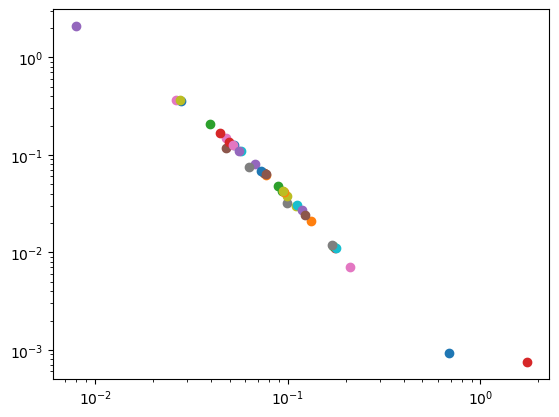

In [49]:
fig, ax = plt.subplots(1)
for r_id,m_id in zip(leak_exchanges, shadow_prices):
    leakage = solution.values[f'{r_id}_r']
    sp = shadow_prices[m_id]
    ax.scatter(-sp, leakage, label = m_id)
plt.yscale('log')
plt.xscale('log')
# plt.legend()

# dFBA

In [50]:
model_name = 'E_coli'
model_name_dict = {model_name: [model, 0.5]}

In [51]:
glucose_mM = utils.convert_gL_to_mM("C6H12O6", 20)

In [52]:
dt = 0.5
total_time = 18
iterations = int(total_time//dt)+1
D = dFBA(iterations = iterations, dt = dt, method = "FBA_with_leakage", store_exchanges_flag = False, fraction_of_optimum=0.8, leakage_params =  {'slope': -3, 'intercept': -4})#(, fraction_of_optimum = 0.95)
D.medium.define_initial_conditions({"M_glc__D_e": glucose_mM})
D.add_models(model_name_dict)
# Set Km and vMax
D.models[model_name].set_km("M_glc__D_e", 50)
D.models[model_name].set_Vmax("M_glc__D_e", 10)
D.models[model_name].lag_time = 2


# D.medium.set_store_concentrations(["glc__D_e", "nh3_e"])
D.run()
print(D.biomass_df)

2023-12-10 01:22:07 INFO:Model E_coli Use FBA with leakage


Candidate metabolites 67:
['M_26dap__M_c', 'M_ac_c', 'M_acgam1p_c', 'M_acser_c', 'M_ade_c', 'M_adn_c', 'M_akg_c', 'M_ala_B_c', 'M_ala__D_c', 'M_ala__L_c', 'M_alaala_c', 'M_amp_c', 'M_arg__L_c', 'M_asn__L_c', 'M_asp__L_c', 'M_btn_c', 'M_cit_c', 'M_cmp_c', 'M_cys__L_c', 'M_ddca_c', 'M_dha_c', 'M_dtmp_c', 'M_dump_c', 'M_f6p_c', 'M_for_c', 'M_fum_c', 'M_g6p_c', 'M_gam6p_c', 'M_gdp_c', 'M_gln__L_c', 'M_glu__L_c', 'M_gly_c', 'M_glyc3p_c', 'M_glyclt_c', 'M_gmp_c', 'M_gtp_c', 'M_hdca_c', 'M_hdcea_c', 'M_his__L_c', 'M_hom__L_c', 'M_ile__L_c', 'M_imp_c', 'M_indole_c', 'M_kdo2lipid4_c', 'M_leu__L_c', 'M_lys__L_c', 'M_mal__L_c', 'M_met__L_c', 'M_orn_c', 'M_orot_c', 'M_phe__L_c', 'M_pheme_c', 'M_pnto__R_c', 'M_pro__L_c', 'M_pser__L_c', 'M_pyr_c', 'M_r5p_c', 'M_ser__L_c', 'M_skm_c', 'M_succ_c', 'M_thr__L_c', 'M_trp__L_c', 'M_tyr__L_c', 'M_uacgam_c', 'M_ump_c', 'M_val__L_c', 'M_xmp_c']


2023-12-10 01:22:10 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 1
2023-12-10 01:22:10 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 2
2023-12-10 01:22:10 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 3


iJO1366 Leak exchanges: 
['R_EX_ac_e', 'R_EX_acser_e', 'R_EX_ade_e', 'R_EX_adn_e', 'R_EX_akg_e', 'R_EX_ala__D_e', 'R_EX_ala__L_e', 'R_EX_alaala_e', 'R_EX_arg__L_e', 'R_EX_asn__L_e', 'R_EX_asp__L_e', 'R_EX_cit_e', 'R_EX_cys__L_e', 'R_EX_dha_e', 'R_EX_for_e', 'R_EX_glu__L_e', 'R_EX_gly_e', 'R_EX_glyc3p_e', 'R_EX_glyclt_e', 'R_EX_his__L_e', 'R_EX_hom__L_e', 'R_EX_ile__L_e', 'R_EX_indole_e', 'R_EX_kdo2lipid4_e', 'R_EX_leu__L_e', 'R_EX_lys__L_e', 'R_EX_mal__L_e', 'R_EX_orn_e', 'R_EX_phe__L_e', 'R_EX_pheme_e', 'R_EX_pro__L_e', 'R_EX_pyr_e', 'R_EX_ser__L_e', 'R_EX_succ_e', 'R_EX_thr__L_e', 'R_EX_trp__L_e', 'R_EX_tyr__L_e', 'R_EX_val__L_e']
####
-3 -4
M_ac_c -2.575370307875779 3.7261109236273366
M_acser_c -1.4292422721975404 0.2877268165926212
M_ade_c -0.8593669642409799 -1.4218991072770604
M_adn_c -0.7558263723339098 -1.7325208829982706
M_akg_c -1.4961890618281553 0.48856718548446576
M_ala__D_c -1.8764003035397592 1.6292009106192777
M_ala__L_c -1.8764003035397592 1.6292009106192777
M_alaala_c

2023-12-10 01:22:13 INFO:Medium   Model biomass E_coli: 0.5, growth rate: 0.47913593078002603


0.5989199134750325 0.47913593078002603 0.8


2023-12-10 01:22:16 INFO:Medium   Model biomass E_coli: 0.6353500350151452, growth rate: 0.5303155490852909


0.6628944363566136 0.5303155490852909 0.8


2023-12-10 01:22:19 INFO:Medium   Model biomass E_coli: 0.8282656138067795, growth rate: 0.5473853066582183


0.6842316333227728 0.5473853066582183 0.8


2023-12-10 01:22:23 INFO:Medium   Model biomass E_coli: 1.0890124851025245, growth rate: 0.551626701814187


0.6895333772677338 0.551626701814187 0.8


2023-12-10 01:22:26 INFO:Medium   Model biomass E_coli: 1.4348849951189346, growth rate: 0.5503404154498454


0.6879255193123067 0.5503404154498454 0.7999999999999999


2023-12-10 01:22:29 INFO:Medium   Model biomass E_coli: 1.8893917543330225, growth rate: 0.5462164969292338


0.6827706211615422 0.5462164969292338 0.8


2023-12-10 01:22:33 INFO:Medium   Model biomass E_coli: 2.482741129164353, growth rate: 0.5398866596026837


0.6748583245033546 0.5398866596026837 0.8


2023-12-10 01:22:36 INFO:Medium   Model biomass E_coli: 3.2521184416493805, growth rate: 0.5306768756514765


0.6633460945643456 0.5306768756514765 0.8


2023-12-10 01:22:39 INFO:Medium   Model biomass E_coli: 4.240346914567587, growth rate: 0.5147879929519616


0.6434849911899521 0.5147879929519616 0.8


2023-12-10 01:22:43 INFO:Medium   Model biomass E_coli: 5.485120769563255, growth rate: 0.49113703987851487


0.6139212998481436 0.49113703987851487 0.8


2023-12-10 01:22:46 INFO:Medium   Model biomass E_coli: 7.011892628455997, growth rate: 0.44865097665847725


0.5608137208230966 0.44865097665847725 0.8


2023-12-10 01:22:48 INFO:Medium   Model biomass E_coli: 8.775231548949769, growth rate: 0.3079001939200373


0.3848752424000466 0.3079001939200373 0.8


2023-12-10 01:22:50 INFO:Medium   Model biomass E_coli: 10.235716840738661, growth rate: 0.13029089026652513


0.1628636128331564 0.13029089026652513 0.8


2023-12-10 01:22:52 INFO:Medium   Model biomass E_coli: 10.924726430477827, growth rate: 0.01649546813450431
2023-12-10 01:22:52 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:52 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0


0.020619335168130387 0.01649546813450431 0.8


2023-12-10 01:22:52 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:52 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:52 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0
2023-12-10 01:22:53 INFO:Medium   Model biomass E_coli: 11.015203270400464, growth rate: 0

dFBA simulation took 44 seconds
    Timepoint  Time     E_coli
0           0   0.0   0.500000
1           1   0.5   0.500000
2           2   1.0   0.500000
3           3   1.5   0.500000
4           4   2.0   0.635350
5           5   2.5   0.828266
6           6   3.0   1.089012
7           7   3.5   1.434885
8           8   4.0   1.889392
9           9   4.5   2.482741
10         10   5.0   3.252118
11         11   5.5   4.240347
12         12   6.0   5.485121
13         13   6.5   7.011893
14         14   7.0   8.775232
15         15   7.5  10.235717
16         16   8.0  10.924726
17         17   8.5  11.015203
18         18   9.0  11.015203
19         19   9.5  11.015203
20         20  10.0  11.015203
21         21  10.5  11.015203
22         22  11.0  11.015203
23         23  11.5  11.015203
24         24  12.0  11.015203
25         25  12.5  11.015203
26         26  13.0  11.015203
27         27  13.5  11.015203
28         28  14.0  11.015203
29         29  14.5  11.015203
30     

# Compare

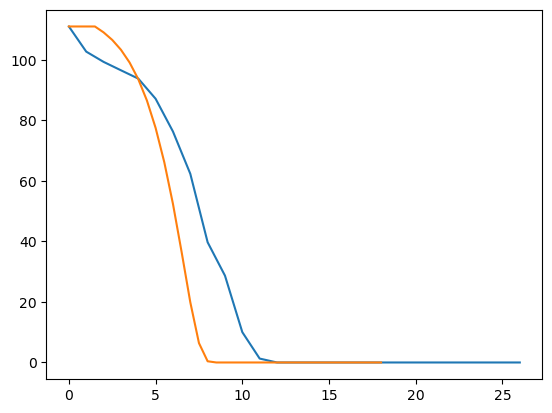

In [53]:
plt.plot(df_glucose.index, df_glucose['Glucose mM'])
plt.plot(dt*D.concentrations_df.index, D.concentrations_df['M_glc__D_e'])

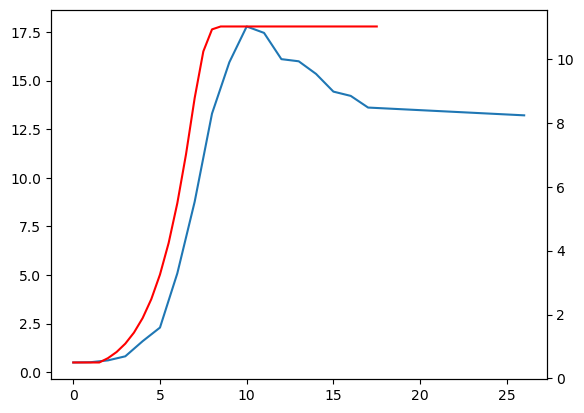

In [54]:
fig, ax = plt.subplots(1)
plt.plot(df_OD.index, df_OD['OD mean'])
ax2 = ax.twinx()
ax2.plot(D.biomass_df['Time'], D.biomass_df['E_coli'], c = 'r')

# Plot

In [55]:
n = 18
timepoints = df_exometabolites.index[:n].values

In [56]:
data = []
idx = np.where((D.concentrations_df.index*dt).isin(timepoints))
# timepoints = df_exometabolites.
for met_abbr, met_id in met_abrv_to_id.items():
    try:
        measured_conc = df_exometabolites.loc[:n, met_abbr]*1e-3
    except KeyError:
        continue
        
    try:
        estimated_conc = D.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        estimated_conc_idx = np.zeros(len(measured_conc))*np.nan
    else:
        estimated_conc_idx = list(estimated_conc.loc[idx])
    for i in range(n):
        data.append([met_abrv_to_name[met_abbr], 'Measured', measured_conc[i], i])
        data.append([met_abrv_to_name[met_abbr], 'Predicted', estimated_conc_idx[i], i])
    
df = pd.DataFrame(data, columns = ['Metabolite', 'Method', 'Concentration [mM]', 'Time'])
        


2023-12-09 22:52:52 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



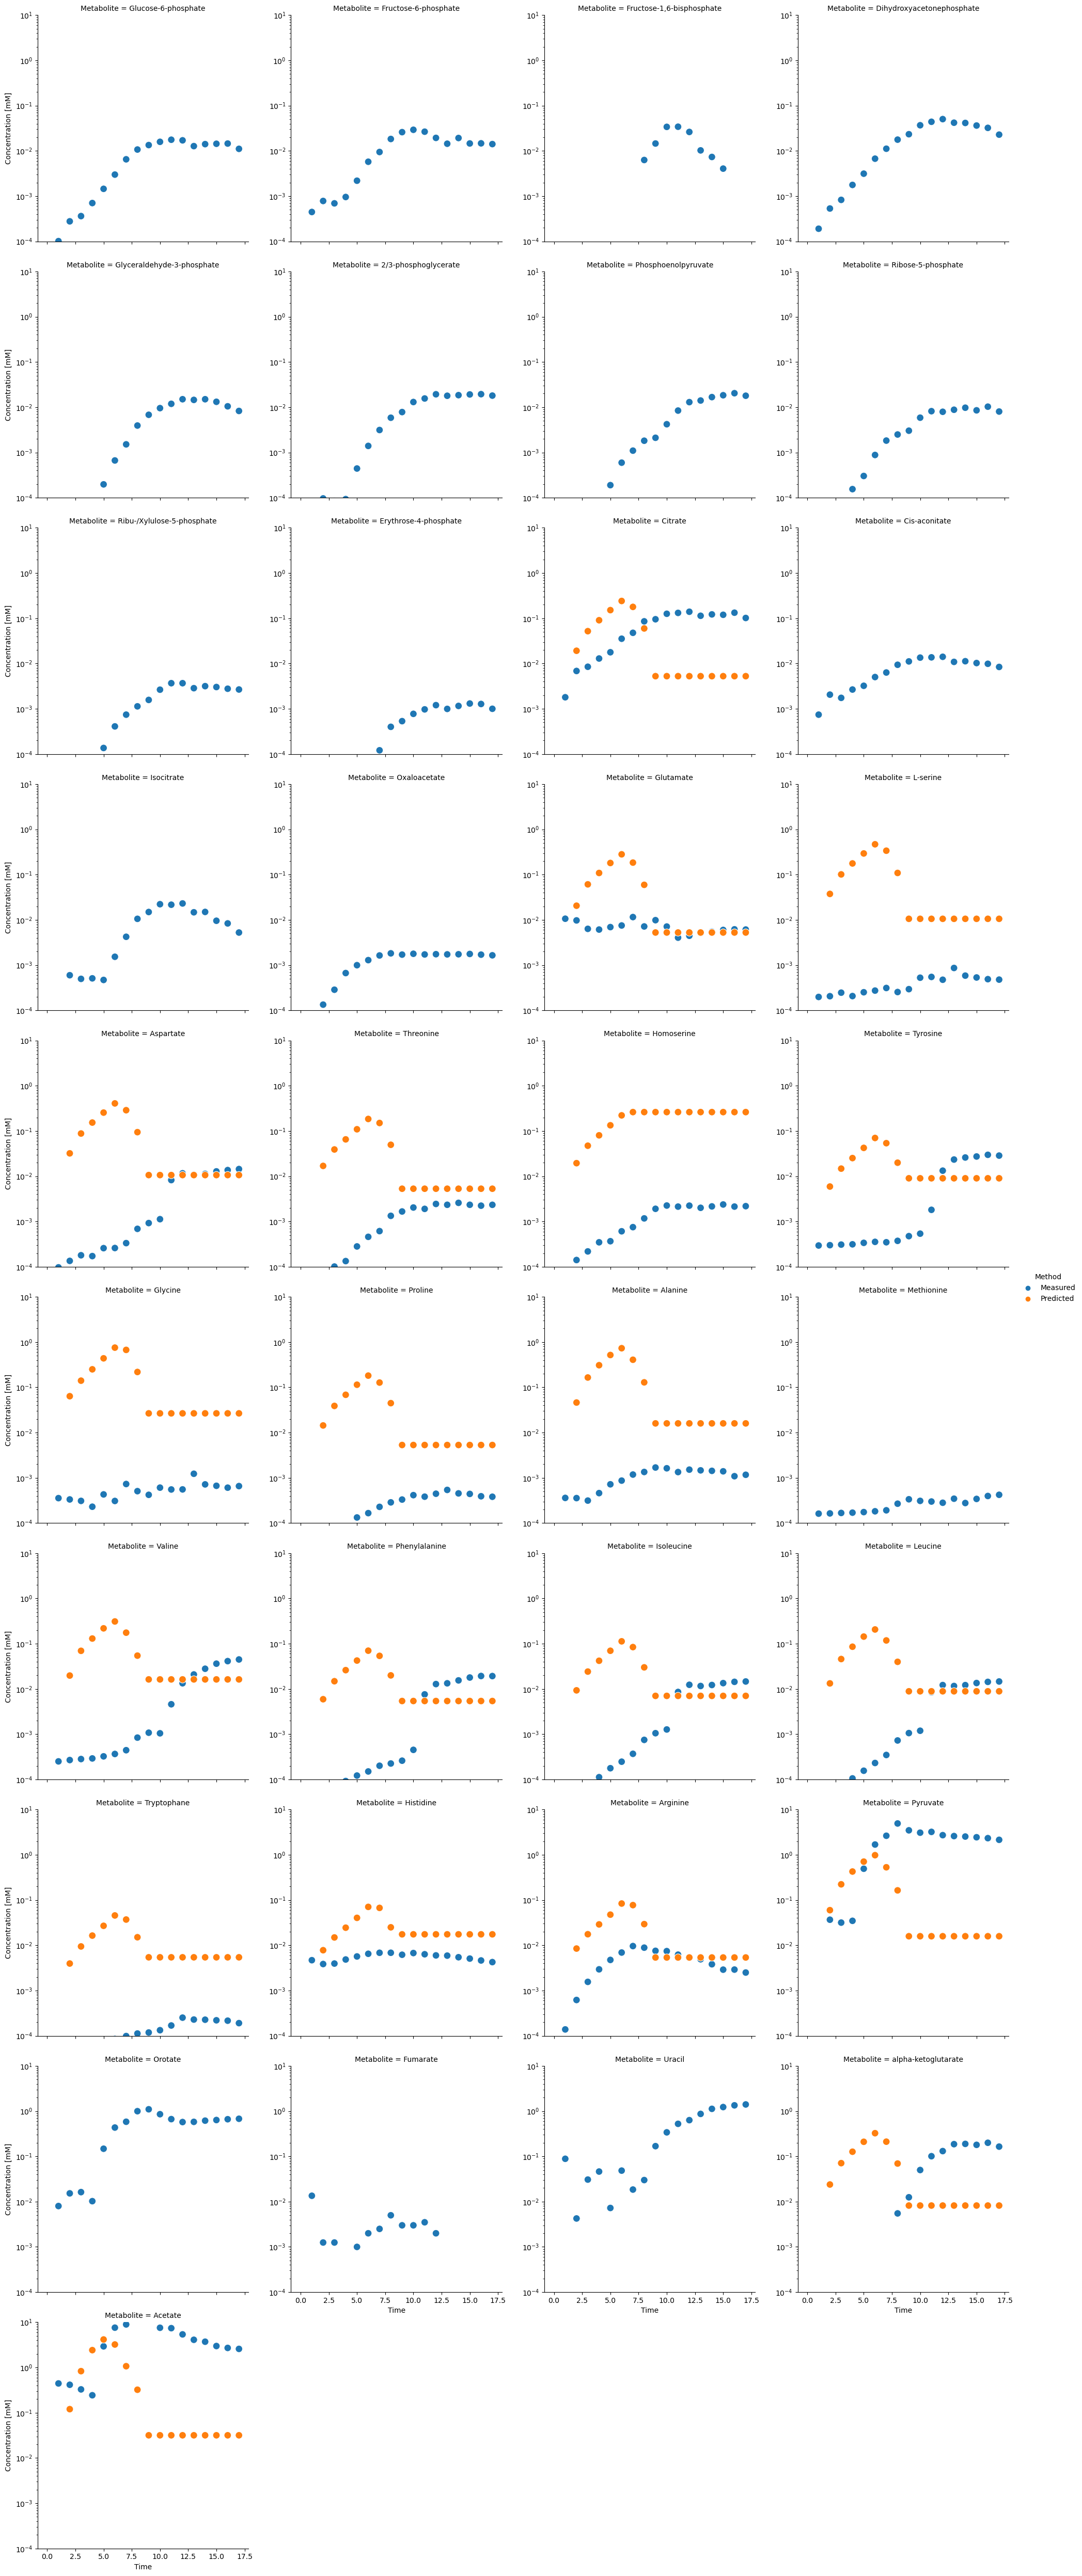

In [23]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':False}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 10)

2023-12-09 22:51:50 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



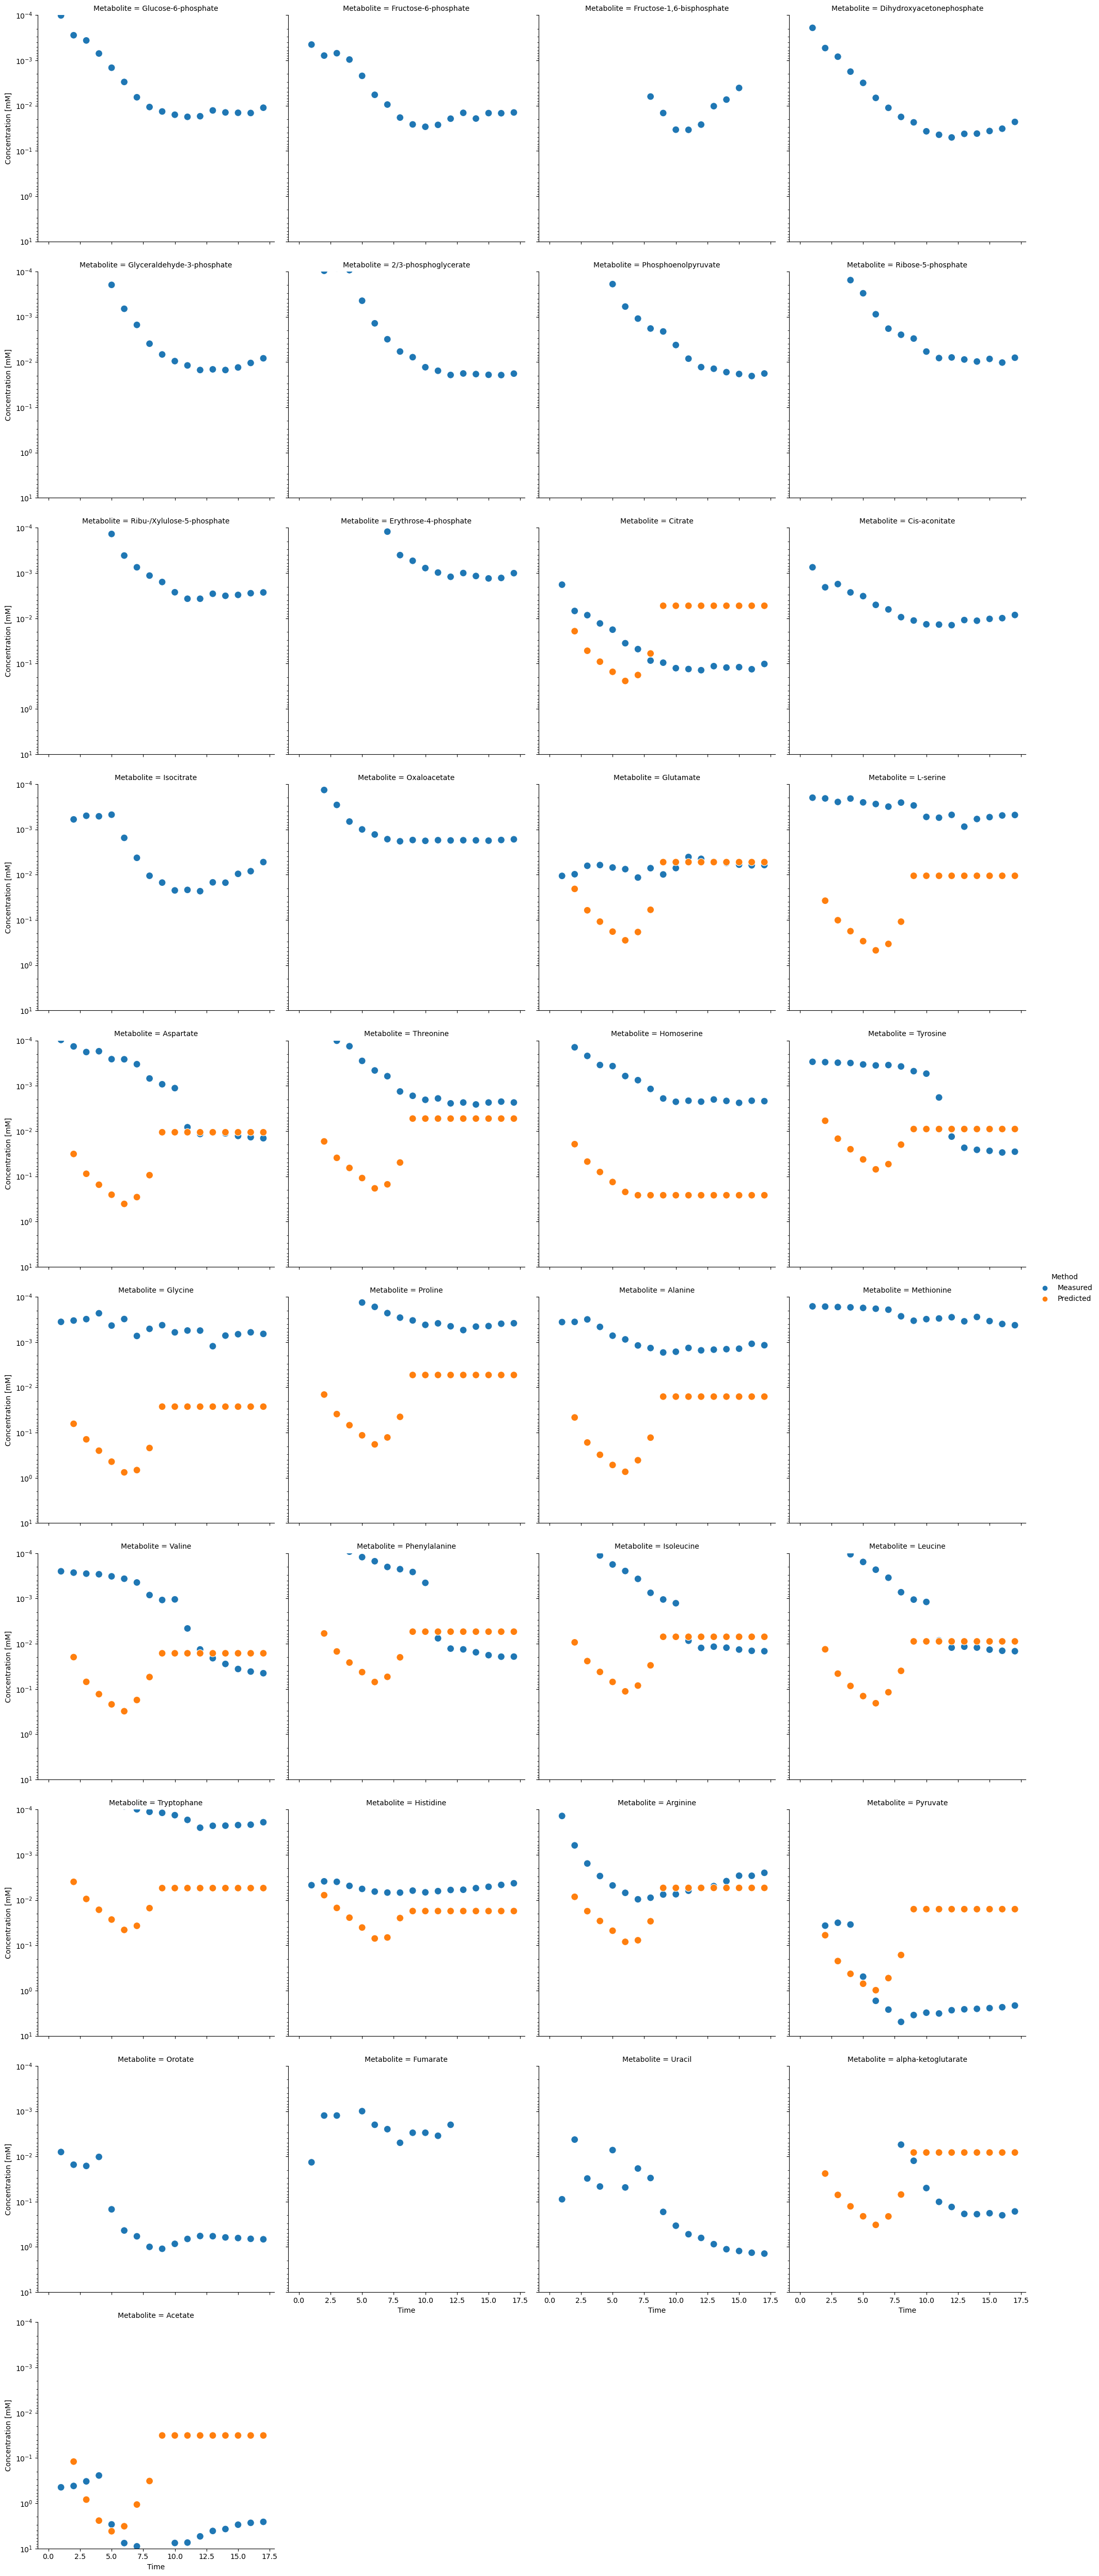

In [22]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':True}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')
    ax.set_ylim(10, 1e-4)

2023-12-09 22:43:34 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



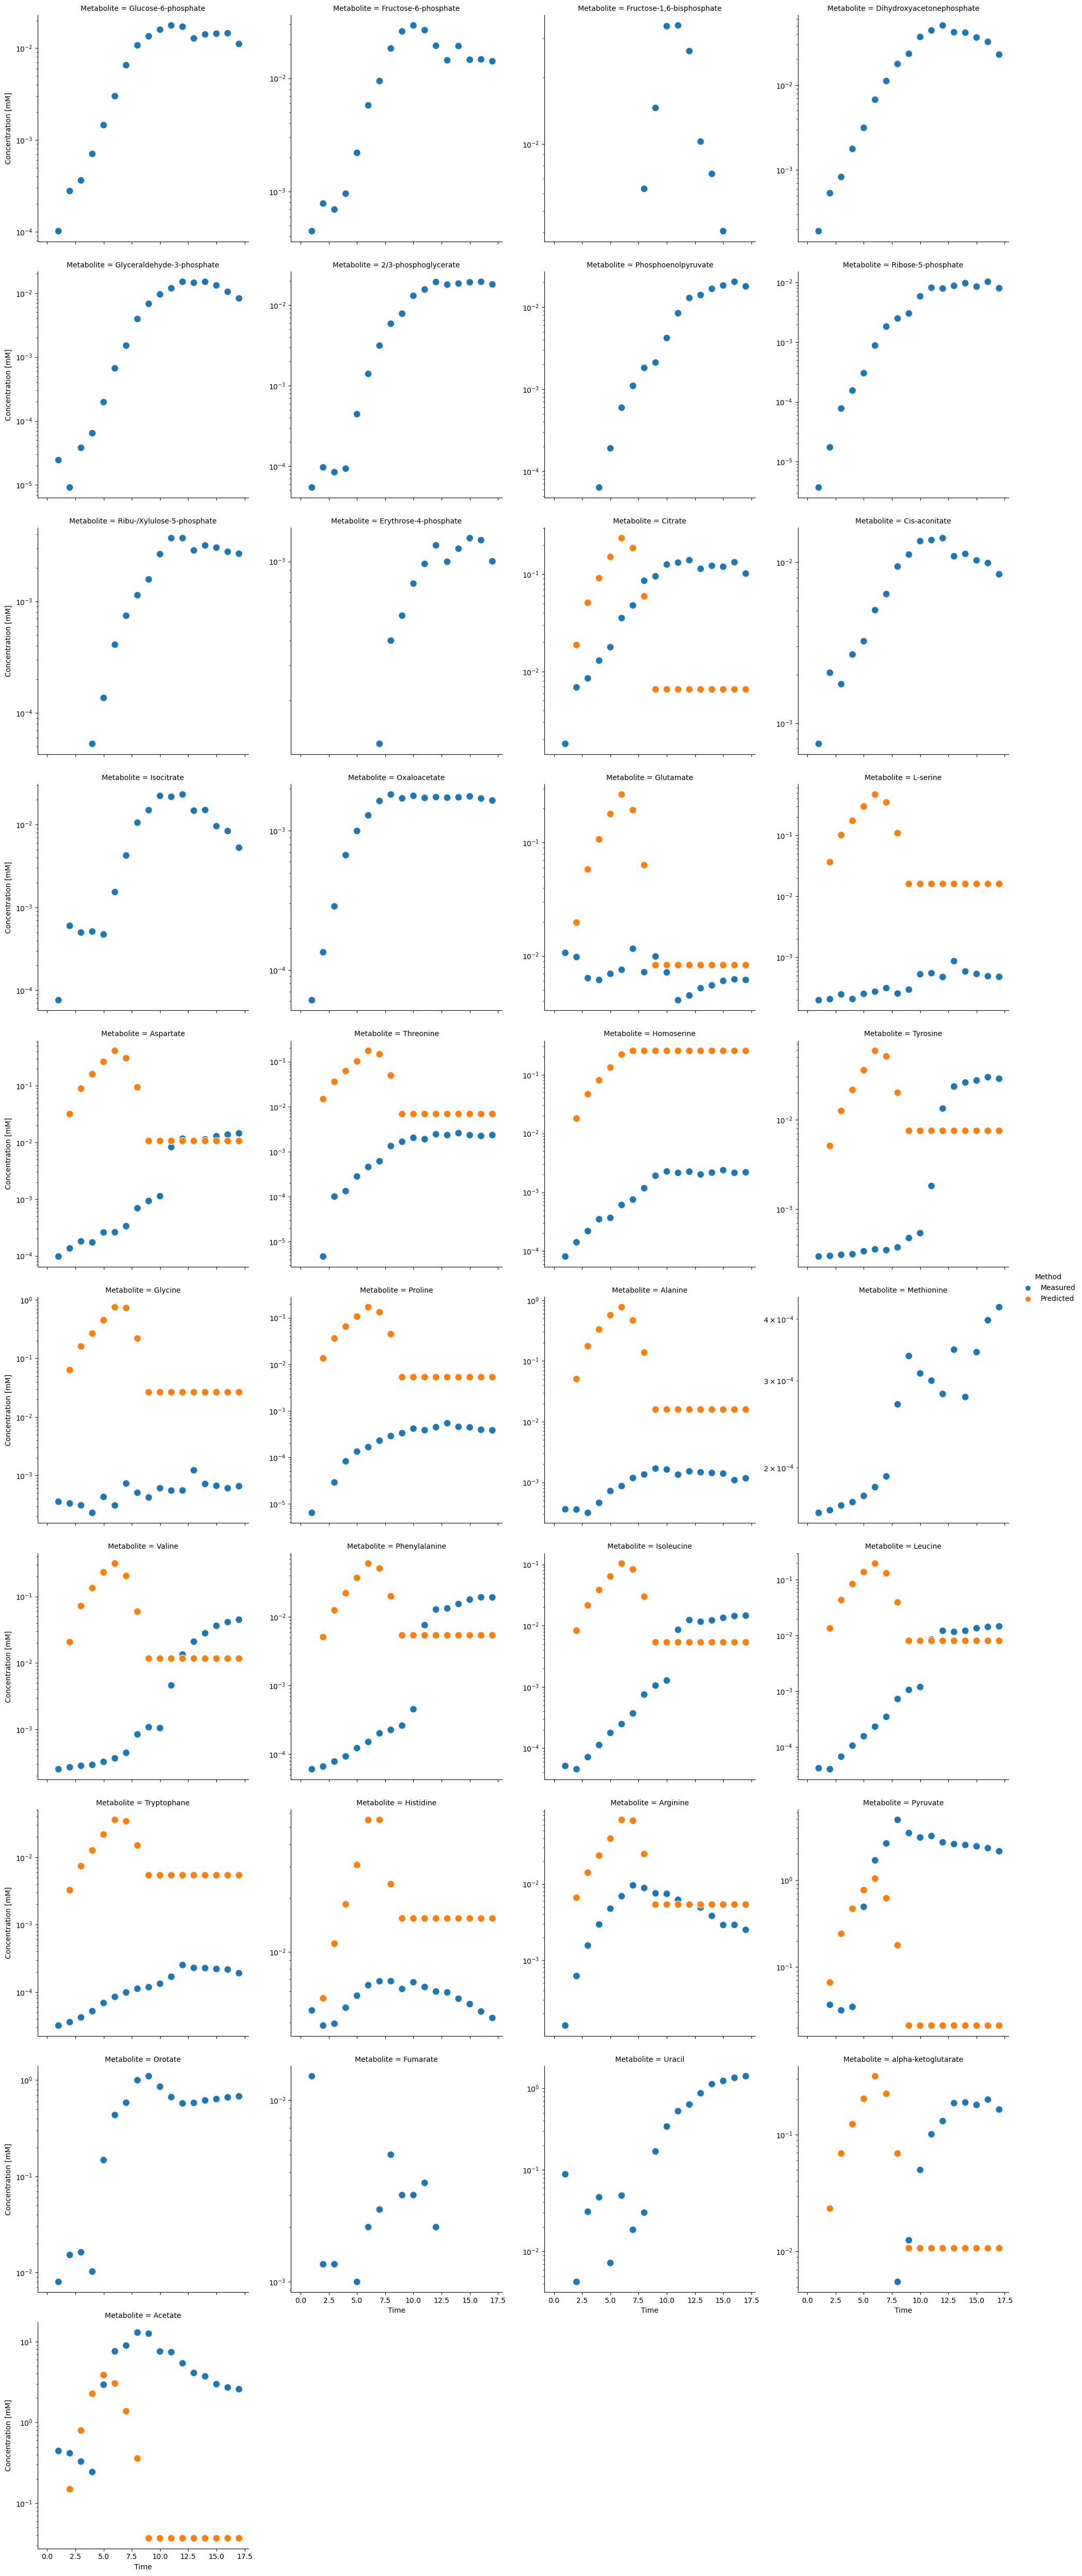

In [64]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':False}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')

2023-12-09 22:41:53 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



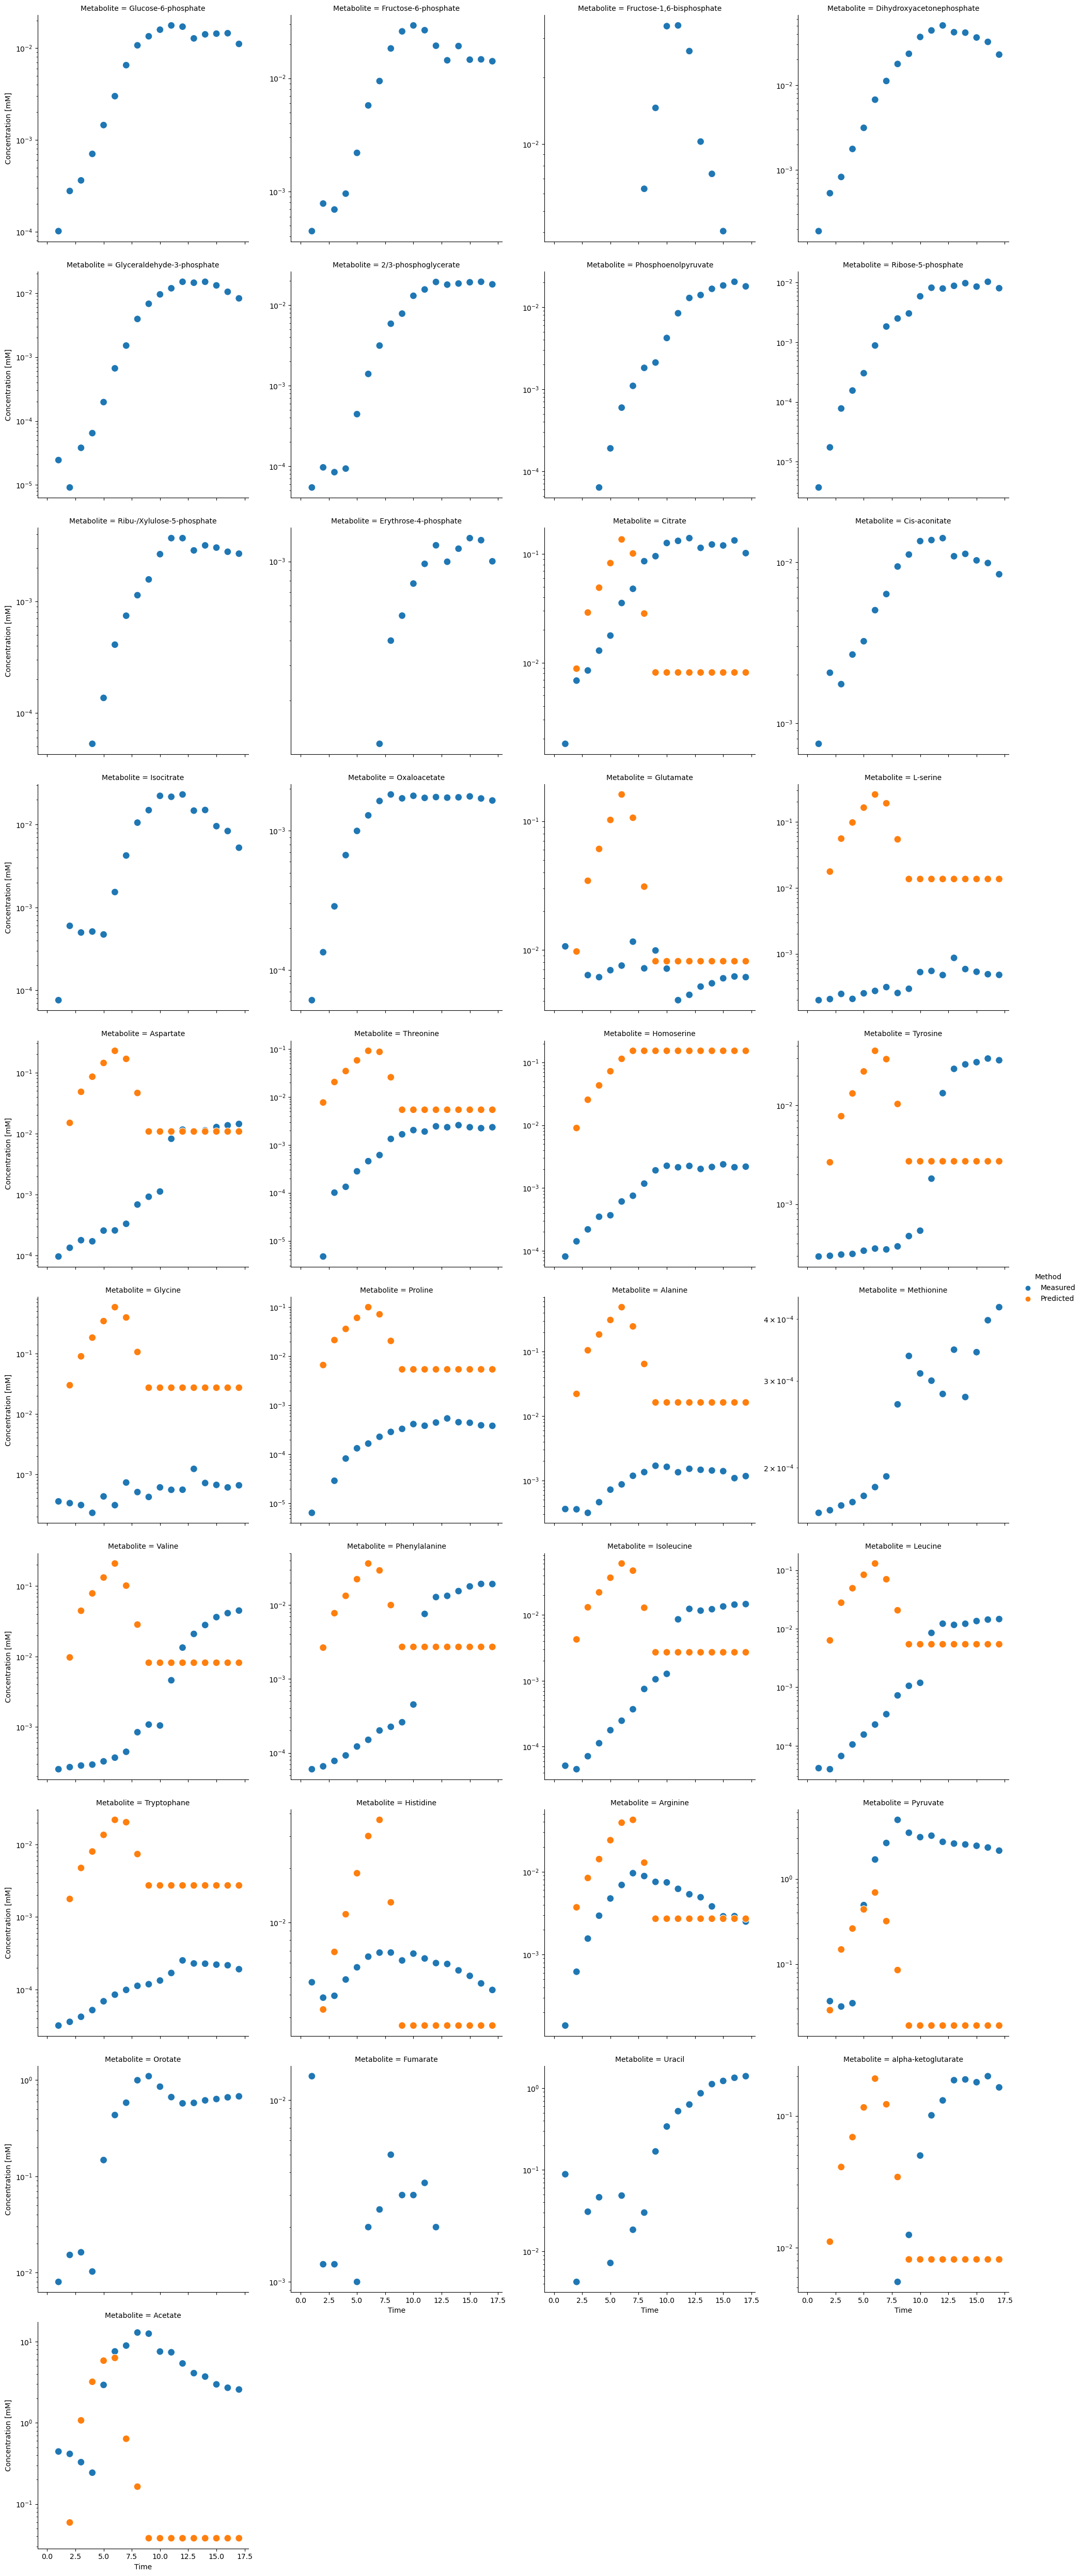

In [50]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':False}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')

In [21]:
estimated_conc_idx

[0.0,
 0.0,
 0.033924075131108525,
 1.1957148895720673,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505,
 1.6742021882915505]

In [159]:
estimated_conc.iloc[idx]

0     0.000000
4     0.000000
8     0.035182
12    0.137382
16    0.234893
20    0.352248
24    0.448824
28    0.374796
32    0.381475
36    0.182782
40    0.013560
44    0.000000
48    0.000000
52    0.000000
56    0.000000
60    0.000000
64    0.000000
68    0.000000
Name: M_ac_e, dtype: float64

In [157]:
estimated_conc

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
68    0.0
69    0.0
70    0.0
71    0.0
72    0.0
Name: M_ac_e, Length: 73, dtype: float64

In [ ]:
pairs = {'ACT'}

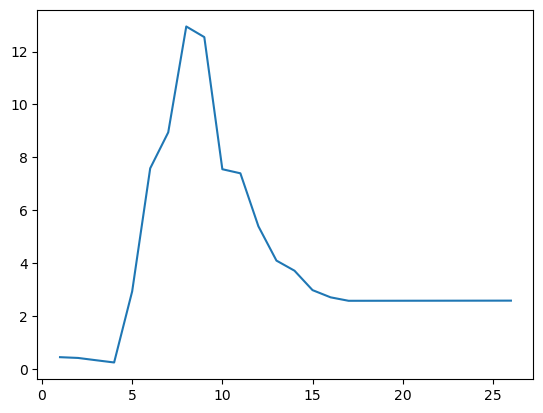

In [180]:
plt.plot(df_exometabolites['ACT']*1e-3)

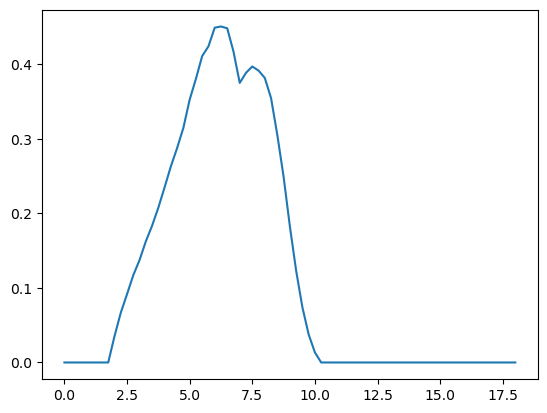

In [181]:
plt.plot(D.concentrations_df.index*dt, D.concentrations_df['M_ac_e'])

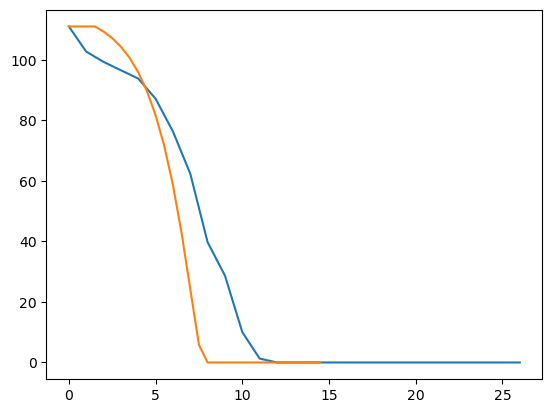

In [61]:
plt.plot(df_glucose.index, df_glucose['Glucose mM'])
plt.plot(dt*D.concentrations_df.index, D.concentrations_df['M_glc__D_e'])